In [1]:
import boto3
from datetime import datetime, timedelta
from botocore import UNSIGNED
from botocore.config import Config
import xarray as xr
import cfgrib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta

In [2]:
sfc_or_prs = 'sfc' # sfc or prs
typeOfLevel = 'surface' if sfc_or_prs == 'sfc' else 'isobaricInhPa'
stepType = 'instant' # instant, max, or accum, but we only want instant
save_path = "C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f01_sfc.grib2"
ds = xr.open_dataset(save_path, engine='cfgrib', filter_by_keys={'stepType': stepType, 'typeOfLevel': typeOfLevel})


Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f01_sfc.grib2.5b7b6.idx' incompatible with GRIB file
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


In [3]:
def get_temp_grid_centered(ds, half_size):   
    lats = ds['latitude'].values  # Shape: (1059, 1799)
    lons = ds['longitude'].values  # Shape: (1059, 1799)
    temp = ds['t'].values         # Shape: (1059, 1799)

    # KBMG coordinates
    target_lat = 39.14
    target_lon = -86.62

    # Check longitude convention and adjust if necessary
    print(f"Longitude range: {lons.min()} to {lons.max()}")
    if lons.min() >= 0 and lons.max() > 180:
        target_lon = 360 + target_lon if target_lon < 0 else target_lon
        print(f"Adjusted target_lon to {target_lon}")  # Should be 273.38

    # Find the closest grid point to KBMG
    lat_diff = np.abs(lats - target_lat)
    lon_diff = np.abs(lons - target_lon)
    comb_diff = lat_diff + lon_diff
    center_y, center_x = np.unravel_index(np.argmin(comb_diff), lats.shape)

    print(f"Center indices: y={center_y}, x={center_x}")
    print(f"Center coords: lat={lats[center_y, center_x]}, lon={lons[center_y, center_x]}")


    grid_size = 2 * half_size + 1  

    temp_grid = np.full((grid_size, grid_size), np.nan, dtype=temp.dtype)
    lat_grid = np.full((grid_size, grid_size), np.nan, dtype=lats.dtype)
    lon_grid = np.full((grid_size, grid_size), np.nan, dtype=lons.dtype)

    for i in range(grid_size):
        for j in range(grid_size):
            dataset_y = center_y - half_size + i
            dataset_x = center_x - half_size + j
            if 0 <= dataset_y < lats.shape[0] and 0 <= dataset_x < lons.shape[1]:
                temp_grid[i, j] = temp[dataset_y, dataset_x] - 273.15
                lat_grid[i, j] = lats[dataset_y, dataset_x]
                lon_grid[i, j] = lons[dataset_y, dataset_x]
    return temp_grid, lat_grid, lon_grid

# Print the result
temp_grid, lat_grid, lon_grid = get_temp_grid_centered(ds, 3)
print("Temperature Grid:")
print(temp_grid)
print("KBMG temp")
print(temp_grid[3, 3])


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
Temperature Grid:
[[-0.8921509 -0.8296509 -0.7671509 -0.7671509 -0.6421509 -0.6421509
  -0.5796509]
 [-0.8296509 -0.8296509 -0.8296509 -0.7671509 -0.6421509 -0.5796509
  -0.7046509]
 [-0.7671509 -0.8296509 -0.8921509 -0.8921509 -0.7046509 -0.6421509
  -0.6421509]
 [-0.7671509 -0.7046509 -0.7671509 -0.6421509 -0.8921509 -0.7046509
  -0.6421509]
 [-0.7671509 -0.8296509 -0.8296509 -0.7671509 -0.7671509 -0.6421509
  -0.7046509]
 [-0.8296509 -0.8921509 -1.2046509 -0.6421509 -0.8921509 -0.7046509
  -0.7046509]
 [-1.0796509 -1.0796509 -1.2046509 -0.9546509 -0.9546509 -0.7671509
  -0.7671509]]
KBMG temp
-0.6421509


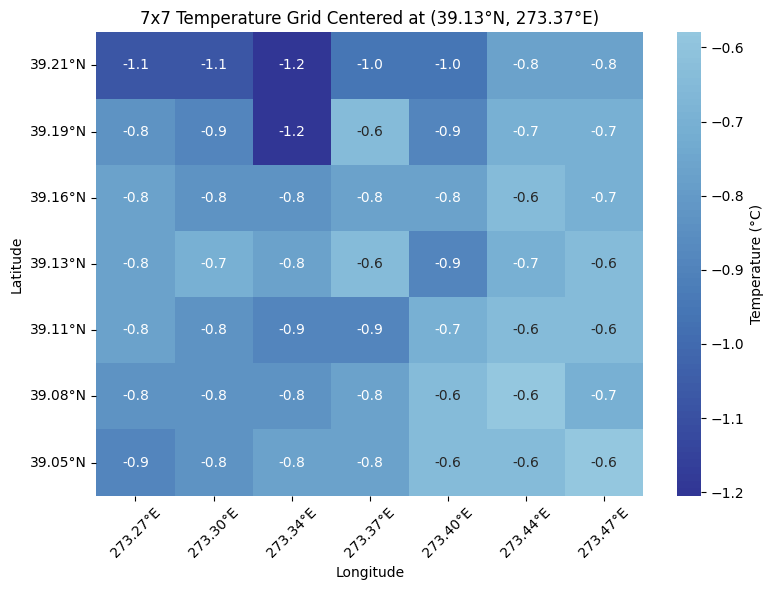

In [4]:
# Calculate n from the grid shape (assuming square grid)
n = temp_grid.shape[0]
half_size = (n - 1) // 2  # Center index, integer for odd n

# Convert temperatures to Celsius (optional, adjust based on your data)
temp_grid_celsius = temp_grid 

# Set up the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(temp_grid_celsius,
            annot=True,          # Show temperature values in each cell
            fmt='.1f',           # Format to 1 decimal place
            cmap='RdYlBu_r',     # Red (hot) to blue (cold), reversed
            cbar_kws={'label': 'Temperature (°C)'},  # Colorbar label
            center=0)            # Center colormap at 0°C


center_lat = lat_grid[half_size, half_size]
center_lon = lon_grid[half_size, half_size]


lat_labels = [f"{lat:.2f}°N" for lat in lat_grid[:, half_size]]
lon_labels = [f"{abs(lon):.2f}°{'W' if lon < 0 else 'E'}" for lon in lon_grid[half_size, :]]


plt.xticks(np.arange(n) + 0.5, lon_labels, rotation=45)
plt.yticks(np.arange(n) + 0.5, lat_labels, rotation=0)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"{n}x{n} Temperature Grid Centered at ({center_lat:.2f}°N, {abs(center_lon):.2f}°{'W' if center_lon < 0 else 'E'})")

plt.gca().invert_yaxis()
plt.tight_layout()

# Display the plot
plt.show()

In [5]:
start_date = datetime(2021, 1, 1)
end_date = datetime(2021, 6, 1)
data = "kbmg.csv"
df = pd.read_csv(data, quotechar='"', skipinitialspace=True, header=0, delimiter=',', engine='python')
df = df[df["CALL_SIGN"].str.strip() == "KBMG"]
dt_tmp = df[["DATE", "TMP"]]
dt_tmp["DATE"] = pd.to_datetime(dt_tmp["DATE"]).dt.round("h")
dt_tmp = dt_tmp.values
prev_time = None
clean_tmp = []
date_list = []
skip_val = "+9999,9"
for dt, tmp in dt_tmp:
    if dt >= start_date and dt <= end_date and dt != prev_time:
        prev_time = dt
        print(dt)
        if tmp.strip() == skip_val:
            continue
        new_tmp = float(int(tmp.strip().split(",")[0])/10)
        clean_tmp.append([dt, new_tmp])
        date_list.append(dt)
    
clean_tmp = np.array(clean_tmp)
obs = clean_tmp[:,1]
obs

C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\2325410424.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_tmp["DATE"] = pd.to_datetime(dt_tmp["DATE"]).dt.round("h")


2021-01-01 00:00:00
2021-01-01 01:00:00
2021-01-01 02:00:00
2021-01-01 03:00:00
2021-01-01 04:00:00
2021-01-01 05:00:00
2021-01-01 06:00:00
2021-01-01 07:00:00
2021-01-01 08:00:00
2021-01-01 09:00:00
2021-01-01 10:00:00
2021-01-01 11:00:00
2021-01-01 12:00:00
2021-01-01 13:00:00
2021-01-01 14:00:00
2021-01-01 15:00:00
2021-01-01 16:00:00
2021-01-01 17:00:00
2021-01-01 18:00:00
2021-01-01 19:00:00
2021-01-01 20:00:00
2021-01-01 21:00:00
2021-01-01 22:00:00
2021-01-01 23:00:00
2021-01-02 00:00:00
2021-01-02 01:00:00
2021-01-02 02:00:00
2021-01-02 03:00:00
2021-01-02 04:00:00
2021-01-02 05:00:00
2021-01-02 06:00:00
2021-01-02 07:00:00
2021-01-02 08:00:00
2021-01-02 09:00:00
2021-01-02 10:00:00
2021-01-02 11:00:00
2021-01-02 12:00:00
2021-01-02 13:00:00
2021-01-02 14:00:00
2021-01-02 15:00:00
2021-01-02 16:00:00
2021-01-02 17:00:00
2021-01-02 18:00:00
2021-01-02 19:00:00
2021-01-02 20:00:00
2021-01-02 21:00:00
2021-01-02 22:00:00
2021-01-02 23:00:00
2021-01-03 00:00:00
2021-01-03 01:00:00


array([-1.7, -2.2, -2.2, ..., 23.9, 23.3, 22.2],
      shape=(3624,), dtype=object)

In [6]:
#If you want to predict more time
lead_time = 24
new_date_list = []
new_obs = []
temp = []
for i in range(len(obs)):
    if i % lead_time == 0:
        new_date_list.append(date_list[i])
    if len(temp) <= lead_time:
        temp.append(obs[i])
        if len(temp) == lead_time:
            new_obs.append(temp)
            temp = []
new_obs = np.array(new_obs)
print(new_obs)
    



[[-1.7 -2.2 -2.2 ...  5.   5.6  5.6]
 [ 7.8  7.8  6.7 ...  1.7  1.7  1.7]
 [ 1.7  1.7  1.7 ...  2.8  2.2  1.7]
 ...
 [12.8 11.7 11.1 ... 15.6 15.  15. ]
 [13.9 11.1 11.7 ... 21.1 20.6 20.6]
 [15.6 12.8 11.7 ... 23.9 23.3 22.2]]


In [7]:
sfc_or_prs = 'sfc' # sfc or prs
typeOfLevel = 'surface' if sfc_or_prs == 'sfc' else 'isobaricInhPa'
stepType = 'instant' # instant, max, or accum, but we only want instant
inp_dataset = []
#date_list = date_list[0:len(date_list)-1]
init_times = [0]
fcst_hours = range(0,25)
debugging = None
try:
    for current_date in date_list:
        print(current_date)
        debugging = current_date
        for init_h in init_times:
            print(init_h)
            init_time = datetime(current_date.year, current_date.month, current_date.day, init_h)
            if current_date.hour < 10:
                temp_hour = f'0{current_date.hour}'
            if current_date.day < 10:
                temp_day = f'0{current_date.day}'
            if current_date.month < 10:
                temp_month = f'0{current_date.month}'
            else:
                temp_hour = str(current_date.hour)
                temp_day = str(current_date.day)
                temp_month = str(current_date.month)
            if current_date.year == 2021 and current_date.month == 1 and current_date.day == 1:
                save_path = f"C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/{str(current_date.year)}{temp_month}{temp_day}_f{temp_hour}_sfc.grib2"
            else:
                save_path = f"C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/{str(current_date.year)}{temp_month}{temp_day}_00z_f{temp_hour}_sfc.grib2"
            ds = xr.open_dataset(save_path, engine='cfgrib', filter_by_keys={'stepType': stepType, 'typeOfLevel': typeOfLevel})
            inp_dataset.append(get_temp_grid_centered(ds, 3)[0])
except:
    print(debugging)
'''
for j in range(1,18):
    for i in range(0,25):
        if j < 10:
            if i < 10:
                save_path = f"C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/2021010{j}_f0{i}_sfc.grib2"
                ds = xr.open_dataset(save_path, engine='cfgrib', filter_by_keys={'stepType': stepType, 'typeOfLevel': typeOfLevel})
                inp_dataset.append(get_temp_grid_centered(ds, 3)[0])
            else:
                save_path = f"C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/2021010{j}_f{i}_sfc.grib2"
                ds = xr.open_dataset(save_path, engine='cfgrib', filter_by_keys={'stepType': stepType, 'typeOfLevel': typeOfLevel})
                inp_dataset.append(get_temp_grid_centered(ds, 3)[0])
        else:
            if i < 10:
                save_path = f"C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/202101{j}_f0{i}_sfc.grib2"
                ds = xr.open_dataset(save_path, engine='cfgrib', filter_by_keys={'stepType': stepType, 'typeOfLevel': typeOfLevel})
                inp_dataset.append(get_temp_grid_centered(ds, 3)[0])
            else:
                save_path = f"C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/202101{j}_f{i}_sfc.grib2"
                ds = xr.open_dataset(save_path, engine='cfgrib', filter_by_keys={'stepType': stepType, 'typeOfLevel': typeOfLevel})
                inp_dataset.append(get_temp_grid_centered(ds, 3)[0])
inp_dataset
'''

Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f00_sfc.grib2.5b7b6.idx' incompatible with GRIB file


2021-01-01 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f01_sfc.grib2.5b7b6.idx' incompatible with GRIB file


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-01 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f02_sfc.grib2.5b7b6.idx' incompatible with GRIB file


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-01 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f03_sfc.grib2.5b7b6.idx' incompatible with GRIB file


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-01 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f04_sfc.grib2.5b7b6.idx' incompatible with GRIB file


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-01 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f05_sfc.grib2.5b7b6.idx' incompatible with GRIB file


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-01 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f06_sfc.grib2.5b7b6.idx' incompatible with GRIB file


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-01 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f07_sfc.grib2.5b7b6.idx' incompatible with GRIB file


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-01 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f08_sfc.grib2.5b7b6.idx' incompatible with GRIB file


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-01 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f09_sfc.grib2.5b7b6.idx' incompatible with GRIB file


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-01 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f09_sfc.grib2.5b7b6.idx' incompatible with GRIB file


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-01 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f09_sfc.grib2.5b7b6.idx' incompatible with GRIB file


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-01 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f09_sfc.grib2.5b7b6.idx' incompatible with GRIB file


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-01 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f09_sfc.grib2.5b7b6.idx' incompatible with GRIB file


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-01 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f09_sfc.grib2.5b7b6.idx' incompatible with GRIB file


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-01 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f09_sfc.grib2.5b7b6.idx' incompatible with GRIB file


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-01 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f09_sfc.grib2.5b7b6.idx' incompatible with GRIB file


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-01 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f09_sfc.grib2.5b7b6.idx' incompatible with GRIB file


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-01 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f09_sfc.grib2.5b7b6.idx' incompatible with GRIB file


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-01 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f09_sfc.grib2.5b7b6.idx' incompatible with GRIB file


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-01 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f09_sfc.grib2.5b7b6.idx' incompatible with GRIB file


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-01 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f09_sfc.grib2.5b7b6.idx' incompatible with GRIB file


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-01 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f09_sfc.grib2.5b7b6.idx' incompatible with GRIB file


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-01 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f09_sfc.grib2.5b7b6.idx' incompatible with GRIB file


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-01 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-31 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-31 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-31 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-31 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-31 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-31 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-31 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-31 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-31 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-31 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-31 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-31 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-31 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-31 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-31 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-31 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-31 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-31 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-31 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-31 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-31 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-31 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-31 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-01 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


'\nfor j in range(1,18):\n    for i in range(0,25):\n        if j < 10:\n            if i < 10:\n                save_path = f"C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/2021010{j}_f0{i}_sfc.grib2"\n                ds = xr.open_dataset(save_path, engine=\'cfgrib\', filter_by_keys={\'stepType\': stepType, \'typeOfLevel\': typeOfLevel})\n                inp_dataset.append(get_temp_grid_centered(ds, 3)[0])\n            else:\n                save_path = f"C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/2021010{j}_f{i}_sfc.grib2"\n                ds = xr.open_dataset(save_path, engine=\'cfgrib\', filter_by_keys={\'stepType\': stepType, \'typeOfLevel\': typeOfLevel})\n                inp_dataset.append(get_temp_grid_centered(ds, 3)[0])\n        else:\n            if i < 10:\n                save_path = f"C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/202101{j}_f0{i}_sfc.grib2"\n                ds = xr.open_dataset(save_path, engine=\'cfgrib\', filte

In [8]:
inp_time = 24
new_date_list = []
new_inp = []
temp = []
for i in range(len(inp_dataset)):
    if i % lead_time == 0:
        new_date_list.append(date_list[i])
    if len(temp) <= inp_time:
        temp.append(inp_dataset[i])
        if len(temp) == inp_time:
            new_inp.append(temp)
            temp = []
new_inp = np.array(new_inp)
print(new_inp)

[[[[-0.8921509  -0.8296509  -0.7671509  ... -0.6421509  -0.6421509
    -0.5796509 ]
   [-0.8296509  -0.8296509  -0.8296509  ... -0.6421509  -0.5796509
    -0.7046509 ]
   [-0.7671509  -0.8296509  -0.8921509  ... -0.7046509  -0.6421509
    -0.6421509 ]
   ...
   [-0.7671509  -0.8296509  -0.8296509  ... -0.7671509  -0.6421509
    -0.7046509 ]
   [-0.8296509  -0.8921509  -1.2046509  ... -0.8921509  -0.7046509
    -0.7046509 ]
   [-1.0796509  -1.0796509  -1.2046509  ... -0.9546509  -0.7671509
    -0.7671509 ]]

  [[-0.8921509  -0.8296509  -0.7671509  ... -0.6421509  -0.6421509
    -0.5796509 ]
   [-0.8296509  -0.8296509  -0.8296509  ... -0.6421509  -0.5796509
    -0.7046509 ]
   [-0.7671509  -0.8296509  -0.8921509  ... -0.7046509  -0.6421509
    -0.6421509 ]
   ...
   [-0.7671509  -0.8296509  -0.8296509  ... -0.7671509  -0.6421509
    -0.7046509 ]
   [-0.8296509  -0.8921509  -1.2046509  ... -0.8921509  -0.7046509
    -0.7046509 ]
   [-1.0796509  -1.0796509  -1.2046509  ... -0.9546509  -0.7

In [9]:
print(new_inp.shape)
print(len(inp_dataset))
print(new_obs.shape)

(151, 24, 7, 7)
3624
(151, 24)


In [8]:
#Todo, make sure the output dataset alligns with the input dataset dates
out_dataset = obs
print(out_dataset.shape)
out_dataset
len(inp_dataset)

(3624,)


3624

In [ ]:
class CNN2DModel(nn.Module):
    def __init__(self):
        super(CNN2DModel, self).__init__()
        # Input: (batch, 24, 7, 7)
        # First conv block: in_channels=24 (time), out_channels=64
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # Now (batch,64,7,7)
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # Now (batch,128,7,7)
            nn.MaxPool2d(kernel_size=2, stride=2)  # -> (batch,128,3,3)
        )
        # Second conv block
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # -> (batch,256,3,3)
            nn.MaxPool2d(kernel_size=3, stride=3)  # -> (batch,256,1,1)
        )
        # After convs, flatten to (batch, 256*1*1 = 256)
        # MLP head to output 24
        self.mlp = nn.Sequential(
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=24)
        )

    def forward(self, x):
        """
        x.shape == (batch_size, 24, 7, 7)
        """
        x = self.conv_block(x)   # -> (batch, 128, 3, 3)
        x = self.conv_block2(x)  # -> (batch, 256, 1, 1)
        x = x.view(x.size(0), -1)  # -> (batch, 256)
        out = self.mlp(x)  # -> (batch, 24)
        return out

# Example of instantiation & moving to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn2d_model = CNN2DModel().to(device)


In [ ]:
class CNN3DModel(nn.Module):
    def __init__(self):
        super(CNN3DModel, self).__init__()
        # Input shape: (batch, 1, 24, 7, 7)
        self.conv3d_block = nn.Sequential(
            nn.Conv3d(in_channels=1, out_channels=32, kernel_size=(3, 3, 3), padding=(1,1,1)),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            # Output: (batch, 32, 24, 7, 7)
            
            nn.Conv3d(in_channels=32, out_channels=64, kernel_size=(3, 3, 3), padding=(1,1,1)),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            # -> (batch, 64, 24, 7, 7)
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2,2,2))
            # -> (batch, 64, 12, 3, 3)
        )
        self.conv3d_block2 = nn.Sequential(
            nn.Conv3d(in_channels=64, out_channels=128, kernel_size=(3,3,3), padding=(1,1,1)),
            nn.BatchNorm3d(128),
            nn.ReLU(),
            # -> (batch,128,12,3,3)
            nn.MaxPool3d(kernel_size=(3, 1, 1), stride=(3,1,1))
            # -> (batch,128,4,3,3)
        )
        # After conv3d_block2: shape = (batch, 128, 4, 3, 3) => flatten to 128*4*3*3 = 4608
        self.fc = nn.Sequential(
            nn.Linear(in_features=128 * 4 * 3 * 3, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=24)
        )

    def forward(self, x):
        """
        x.shape == (batch_size, 24, 7, 7)
        """
        x = x.unsqueeze(1)  # -> (batch, 1, 24, 7, 7)
        x = self.conv3d_block(x)   # -> (batch,64,12,3,3)
        x = self.conv3d_block2(x)  # -> (batch,128,4,3,3)
        x = x.view(x.size(0), -1)  # -> (batch, 128*4*3*3 = 4608)
        out = self.fc(x)           # -> (batch, 24)
        return out

# Instantiate & move
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn3d_model = CNN3DModel().to(device)


In [ ]:
class SpatialTemporalLSTM(nn.Module):
    def __init__(self, cnn_embed_dim=64, lstm_hidden=128, lstm_layers=2):
        super(SpatialTemporalLSTM, self).__init__()
        # A small CNN to turn each 7×7 grid (per time step) into a vector of size cnn_embed_dim
        self.spatial_cnn = nn.Sequential(
            # Input per-step shape: (batch, 1, 7, 7)
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=cnn_embed_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))  # -> (batch, cnn_embed_dim, 1, 1)
        )
        # LSTM to process sequence of length 24, each with feature size cnn_embed_dim
        self.lstm = nn.LSTM(
            input_size=cnn_embed_dim,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,  # expects (batch, seq_len, input_size)
            dropout=0.1
        )
        # Final linear head: from LSTM hidden dimension to 24 outputs
        self.fc = nn.Linear(in_features=lstm_hidden, out_features=24)

    def forward(self, x):
        """
        x.shape == (batch_size, 24, 7, 7)
        """
        batch_size = x.size(0)
        seq_len = x.size(1)  # 24

        # Reshape so we can feed each time slice through the spatial CNN
        # Current x: (batch, 24, 7, 7). We want: (batch*24, 1, 7, 7)
        x_reshaped = x.view(batch_size * seq_len, 1, 7, 7)
        # Pass through spatial CNN → (batch*24, cnn_embed_dim, 1, 1)
        spatial_feat = self.spatial_cnn(x_reshaped)
        # Remove trailing dims → (batch*24, cnn_embed_dim)
        spatial_feat = spatial_feat.view(batch_size, seq_len, -1)  # -> (batch,24,cnn_embed_dim)

        # Pass sequence into LSTM
        lstm_out, _ = self.lstm(spatial_feat)  # -> (batch,24,lstm_hidden)
        # If you want to predict a 24‐step output as a sequence, you can do:
        #   out = self.fc(lstm_out)  # (batch,24,24)
        # But here, we want a length‐24 vector per batch. We can either use the LSTM's last hidden state:
        last_hidden = lstm_out[:, -1, :]         # (batch, lstm_hidden)
        out = self.fc(last_hidden)               # (batch, 24)
        return out

# Instantiate & move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
st_lstm_model = SpatialTemporalLSTM(cnn_embed_dim=64, lstm_hidden=128, lstm_layers=2).to(device)


In [ ]:
class SpatialTemporalTransformer(nn.Module):
    def __init__(
        self,
        embed_dim: int = 64,
        nhead: int = 8,
        num_layers: int = 2,
        ff_dim: int = 128,
        dropout: float = 0.1
    ):
        super(SpatialTemporalTransformer, self).__init__()
        # Flatten 7×7 → 49, then embed to `embed_dim`
        self.spatial_embedding = nn.Sequential(
            nn.Flatten(),              # (batch, 49)
            nn.Linear(in_features=49, out_features=embed_dim),
            nn.ReLU()
        )
        # Positional embeddings: one per time-step (24 total)
        self.pos_embed = nn.Parameter(torch.randn(24, embed_dim))

        # Transformer encoder layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=nhead,
            dim_feedforward=ff_dim,
            dropout=dropout,
            activation='relu'
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers
        )
        # Final head: we pool over the 24 output tokens and project to 24 dims
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(in_features=embed_dim, out_features=24)

    def forward(self, x):
        """
        x.shape == (batch_size, 24, 7, 7)
        We want to produce (batch_size, 24)
        """
        batch_size = x.size(0)
        seq_len = x.size(1)  # should be 24

        # 1) Per‐step spatial embedding
        # Reshape so each time‐slice is a separate sample: (batch*24, 1,7,7)
        x_flat = x.view(batch_size * seq_len, 1, 7, 7)
        # Each slice → (batch*24, embed_dim)
        step_feat = self.spatial_embedding(x_flat)
        # Reshape back to (batch, 24, embed_dim)
        step_feat = step_feat.view(batch_size, seq_len, -1)  # (batch,24,embed_dim)

        # 2) Add positional embeddings: broadcast pos_embed to batch dimension
        # pos_embed: (24, embed_dim) → (1,24,embed_dim) → broadcast
        pe = self.pos_embed.unsqueeze(0)  # (1, 24, embed_dim)
        x_in = step_feat + pe             # (batch, 24, embed_dim)

        # 3) Transformer expects shape = (seq_len, batch, embed_dim)
        x_in = x_in.permute(1, 0, 2)  # → (24, batch, embed_dim)
        x_encoded = self.transformer_encoder(x_in)  # (24, batch, embed_dim)

        # 4) Permute back to (batch, 24, embed_dim)
        x_encoded = x_encoded.permute(1, 0, 2)  # → (batch, 24, embed_dim)
        # 5) Pool across the “sequence” dimension to get one vector per batch
        #    .permute to (batch, embed_dim, 24) for 1D pooling:
        x_pooled = x_encoded.permute(0, 2, 1)    # (batch, embed_dim, 24)
        x_pooled = self.pool(x_pooled)          # (batch, embed_dim, 1)
        x_pooled = x_pooled.squeeze(-1)         # (batch, embed_dim)

        # 6) Final projection to 24 outputs
        out = self.fc(x_pooled)  # (batch, 24)
        return out

# Instantiate & move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
st_transformer = SpatialTemporalTransformer(
    embed_dim=64,
    nhead=8,
    num_layers=2,
    ff_dim=128,
    dropout=0.1
).to(device)


Using device: cuda
Epoch [10/150], Train MSE: 97.9228, Train MAE: 7.4022, Test MSE: 97.7058, Test MAE: 7.3528
Epoch [20/150], Train MSE: 51.2215, Train MAE: 5.3943, Test MSE: 52.6579, Test MAE: 5.5413
Epoch [30/150], Train MSE: 33.2866, Train MAE: 4.4199, Test MSE: 35.3847, Test MAE: 4.6759
Epoch [40/150], Train MSE: 28.0885, Train MAE: 4.0336, Test MSE: 30.3726, Test MAE: 4.3885
Epoch [50/150], Train MSE: 27.4291, Train MAE: 4.0044, Test MSE: 30.3809, Test MAE: 4.3973
Epoch [60/150], Train MSE: 26.7232, Train MAE: 3.9339, Test MSE: 29.7667, Test MAE: 4.3528
Epoch [70/150], Train MSE: 26.0487, Train MAE: 3.8921, Test MSE: 29.1358, Test MAE: 4.3284
Epoch [80/150], Train MSE: 25.2975, Train MAE: 3.8408, Test MSE: 28.0633, Test MAE: 4.2710
Epoch [90/150], Train MSE: 24.9750, Train MAE: 3.7926, Test MSE: 26.6812, Test MAE: 4.1958
Epoch [100/150], Train MSE: 23.9901, Train MAE: 3.7293, Test MSE: 24.8210, Test MAE: 4.0853
Epoch [110/150], Train MSE: 23.4094, Train MAE: 3.6788, Test MSE: 25.6

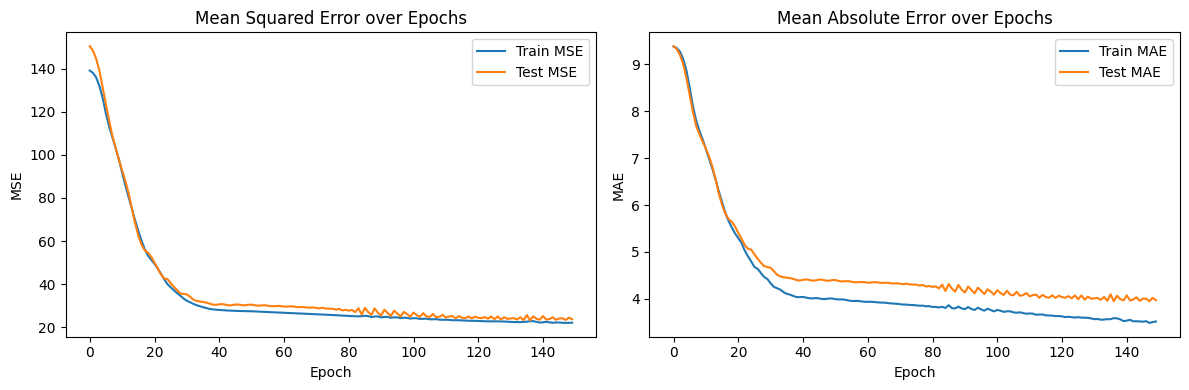

In [14]:
x = new_inp
y = new_obs

#code for multiple dim output
X = torch.FloatTensor(x)
Y = torch.FloatTensor(y)

# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Check GPU availability and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")  # Confirm GPU is being used

# Move all data to the GPU
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# Define the neural network model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.network = nn.Sequential(
            nn.Linear(24 * 7 * 7, 512),  # Input: 24*7*7=1176 -> 512
            nn.ReLU(),
            nn.Linear(512, 256),  
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),     # Hidden layer: 64 -> 32
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 24)           # Output: 32 -> 24
        )
    
    def forward(self, x):
        x = self.flatten(x)  # Flatten from (batch_size, 24, 7, 7) to (batch_size, 1176)
        return self.network(x)

# Initialize the model and move it to the GPU
model = SimpleNN().to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
num_epochs = 150

# Lists to store metrics
train_losses = []
train_maes = []
test_losses = []
test_maes = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    outputs = model(X_train)  # Forward pass: (num_train, 24, 7, 7) -> (num_train, 24)
    loss = criterion(outputs, y_train)  # Shapes: (num_train, 24) vs (num_train, 24)
    mae = torch.mean(torch.abs(outputs - y_train)).item()  # MAE over all elements
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Store training metrics
    train_losses.append(loss.item())
    train_maes.append(mae)
    
    # Evaluation phase
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)  # (num_test, 24, 7, 7) -> (num_test, 24)
        test_loss = criterion(test_outputs, y_test).item()
        test_mae = torch.mean(torch.abs(test_outputs - y_test)).item()
        test_losses.append(test_loss)
        test_maes.append(test_mae)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train MSE: {loss.item():.4f}, Train MAE: {mae:.4f}, "
              f"Test MSE: {test_loss:.4f}, Test MAE: {test_mae:.4f}")
        
torch.save(model, 'BasicDNN(512-256-128-64-32-24).pth')

# Plotting results
plt.figure(figsize=(12, 4))

# Plot Mean Squared Error
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train MSE')
plt.plot(test_losses, label='Test MSE')
plt.title('Mean Squared Error over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

# Plot Mean Absolute Error
plt.subplot(1, 2, 2)
plt.plot(train_maes, label='Train MAE')
plt.plot(test_maes, label='Test MAE')
plt.title('Mean Absolute Error over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#Code for 1 dim output 
x = np.array(inp_dataset) #shape (25,7,7)
y = np.array([float(val) for val in obs]) #shape (25,)

X = torch.FloatTensor(x)
Y = torch.FloatTensor(y)

# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Check GPU availability and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")  # Confirm GPU is being used

# Move all data to the GPU
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# Define the neural network model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.network = nn.Sequential(
            nn.Linear(7 * 7, 512),  # Input: 49 (7x7 flattened) -> 64
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),     # Hidden layer: 64 -> 32
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)       # Output: 32 -> 1 (regression)
        )
    
    def forward(self, x):
        x = self.flatten(x)  # Flatten from (batch_size, 7, 7) to (batch_size, 49)
        return self.network(x)

# Initialize the model and move it to the GPU
model = SimpleNN().to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
num_epochs = 150

# Lists to store metrics
train_losses = []
train_maes = []
test_losses = []
test_maes = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    outputs = model(X_train)  # Forward pass on GPU
    loss = criterion(outputs, y_train.unsqueeze(1))  # Match shapes: (batch_size, 1)
    mae = torch.mean(torch.abs(outputs - y_train.unsqueeze(1))).item()  # MAE as scalar
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Store training metrics
    train_losses.append(loss.item())
    train_maes.append(mae)
    
    # Evaluation phase
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test.unsqueeze(1)).item()
        test_mae = torch.mean(torch.abs(test_outputs - y_test.unsqueeze(1))).item()
        test_losses.append(test_loss)
        test_maes.append(test_mae)
    
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train MSE: {loss.item():.4f}, Train MAE: {mae:.4f}, "
              f"Test MSE: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# Plotting results
plt.figure(figsize=(12, 4))

# Plot Mean Squared Error
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train MSE')
plt.plot(test_losses, label='Test MSE')
plt.title('Mean Squared Error over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

# Plot Mean Absolute Error
plt.subplot(1, 2, 2)
plt.plot(train_maes, label='Train MAE')
plt.plot(test_maes, label='Test MAE')
plt.title('Mean Absolute Error over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()
#calculate loss, accuracy for each epoch and then plot them

Using device: cuda


AttributeError: partially initialized module 'torch._dynamo' from 'c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\torch\_dynamo\__init__.py' has no attribute 'config' (most likely due to a circular import)

In [15]:
from numpy import absolute


Absulute_err = []
inp_exe = [datetime(2021,6,18),datetime(2021,6,19),datetime(2022, 12, 22),datetime(2022, 12, 22),datetime(2023, 3, 31),datetime(2023, 4, 1)]
i = 0
while i < len(inp_exe) - 1: 
    curr_date = inp_exe[i]
    end_date = inp_exe[i+1]
    while curr_date <= end_date:
        inp_ex = []
        out_ex = []
        for j in range(0,24):
            if j >= 10:
                hour = f'{j}'
            elif j < 10:
                hour = f'0{j}'
            if curr_date.month < 10:
                month =  f'0{curr_date.month}'
            elif curr_date.month >= 10:
                month =  f'{curr_date.month}'
            if curr_date.day < 10:
                day =  f'0{curr_date.day}'
            elif curr_date.day >= 10:
                day =  f'{curr_date.day}'
            year = str(curr_date.year)
            example_input = f"C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/mod_testing/{year}{month}{day}_00z_f{hour}_sfc.grib2"
            ds = xr.open_dataset(example_input, engine='cfgrib', filter_by_keys={'stepType': stepType, 'typeOfLevel': typeOfLevel})
            inp_ex.append(get_temp_grid_centered(ds, 3)[0])
            print(datetime(curr_date.year, curr_date.month, curr_date.day, j, 0, 0))
            actual_tmp_df = df[["DATE", "TMP"]]
            actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
            tmp_val = actual_tmp_df[actual_tmp_df["DATE"] == datetime(curr_date.year, curr_date.month, curr_date.day, j, 0, 0)].iat[0,1]
            real_tmp_val = float(int(tmp_val.strip().split(",")[0])/10)
            out_ex.append(real_tmp_val)
        print(len(inp_ex))
        print(len(out_ex))
        final_example = np.array(inp_ex)
        print(final_example)
        input_tensor = torch.FloatTensor(final_example).unsqueeze(0).to(device)
        model.eval()
        with torch.no_grad():
            output = model(input_tensor)
            predicted_value = output.tolist()[0]
        print(f"Predicted value: {predicted_value}")
        print(len(predicted_value))
        Absulute_err.append([abs(predicted_value[i] - out_ex[i]) for i in range(len(out_ex))])
        curr_date += timedelta(days=1)
    i += 2

print(Absulute_err)




'''
example_input = "C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/mod_testing/20210301_00z_f00_sfc.grib2"
ds = xr.open_dataset(example_input, engine='cfgrib', filter_by_keys={'stepType': stepType, 'typeOfLevel': typeOfLevel})
inp_ex.append(get_temp_grid_centered(ds, 3)[0])
final_example = np.array(inp_ex)
print(final_example)
input_tensor = torch.FloatTensor(final_example).unsqueeze(0).to(device)
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    predicted_value = output.item()

print(f"Predicted value: {predicted_value}")
'''

c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-18 00:00:00


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-18 01:00:00


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-18 02:00:00


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-18 03:00:00


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-18 04:00:00


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-18 05:00:00


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-18 06:00:00


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-18 07:00:00


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-18 08:00:00


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-18 09:00:00


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-18 10:00:00


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-18 11:00:00


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-18 12:00:00


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-18 13:00:00


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-18 14:00:00


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-18 15:00:00


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-18 16:00:00


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-18 17:00:00


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-18 18:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-18 19:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-18 20:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-18 21:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-18 22:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-18 23:00:00
24
24
[[[27.722992 27.222992 27.035492 ... 27.160492 27.722992 27.972992]
  [27.472992 27.222992 26.910492 ... 27.347992 27.347992 27.347992]
  [27.722992 27.347992 26.785492 ... 26.847992 27.285492 27.035492]
  ...
  [27.222992 27.347992 27.160492 ... 27.035492 27.660492 27.722992]
  [27.535492 27.597992 28.097992 ... 27.222992 27.597992 26.785492]
  [27.597992 28.035492 28.285492 ... 27.535492 27.722992 27.222992]]

 [[25.31601  24.56601  24.06601  ... 24.50351  25.31601  25.50351 ]
  [24.94101  24.87851  24.87851  ... 25.06601  25.00351  24.94101 ]
  [25.12851  24.94101  24.56601  ... 24.44101  25.00351  24.87851 ]
  ...
  [24.81601  24.75351  24.37851  ... 24.50351  25.12851  25.37851 ]
  [25.00351  24.81601  25.00351  ... 24.56601  25.06601  24.44101 ]
  [25.00351  25.12851  25.06601  

C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-19 00:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-19 01:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-19 02:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-19 03:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-19 04:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-19 05:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-19 06:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-19 07:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-19 08:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-19 09:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-19 10:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-19 11:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-19 12:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-19 13:00:00


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-19 14:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-19 15:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-19 16:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-19 17:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-19 18:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-19 19:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-19 20:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-19 21:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-19 22:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-19 23:00:00
24
24
[[[30.19754  29.57254  28.19754  ... 29.26004  30.76004  31.32254 ]
  [29.88504  30.51004  29.76004  ... 29.51004  29.44754  29.51004 ]
  [30.76004  30.88504  30.01004  ... 28.94754  29.13504  29.13504 ]
  ...
  [29.13504  29.57254  30.01004  ... 30.63504  31.32254  31.01004 ]
  [28.19754  28.19754  29.07254  ... 31.69754  31.88504  30.19754 ]
  [29.13504  28.07254  27.82254  ... 30.69754  31.51004  31.76004 ]]

 [[28.147552 27.772552 26.710052 ... 27.210052 28.585052 29.272552]
  [27.772552 27.897552 27.460052 ... 26.960052 27.085052 27.710052]
  [27.460052 27.710052 27.022552 ... 26.460052 26.897552 27.335052]
  ...
  [26.397552 26.460052 26.147552 ... 26.147552 26.710052 26.772552]
  [26.085052 25.897552 25.960052 ... 26.085052 26.210052 25.960052]
  [26.022552 25.835052 25.647552 

C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2022-12-22 00:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2022-12-22 01:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2022-12-22 02:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2022-12-22 03:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2022-12-22 04:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2022-12-22 05:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2022-12-22 06:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2022-12-22 07:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2022-12-22 08:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2022-12-22 09:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2022-12-22 10:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2022-12-22 11:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2022-12-22 12:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2022-12-22 13:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2022-12-22 14:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2022-12-22 15:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2022-12-22 16:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2022-12-22 17:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2022-12-22 18:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2022-12-22 19:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2022-12-22 20:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2022-12-22 21:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2022-12-22 22:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2022-12-22 23:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


24
24
[[[ 2.2085266   2.2710266   2.2710266  ...  1.2710266   1.0835266
    1.2710266 ]
  [ 1.8335266   2.1460266   1.3335266  ...  1.0210266   1.2085266
    1.2085266 ]
  [ 1.6460266   2.0835266   1.5210266  ...  1.0835266   0.7710266
    1.0835266 ]
  ...
  [ 2.1460266   1.7085266   1.3960266  ...  1.2710266   1.1460266
    1.3960266 ]
  [ 2.4585266   1.8335266   1.6460266  ...  1.0835266   1.3335266
    1.5210266 ]
  [ 1.5835266   1.3960266   1.6460266  ...  1.2710266   0.9585266
    1.8960266 ]]

 [[ 2.2536316   2.2536316   2.1911316  ...  0.8786316   0.6911316
    0.9411316 ]
  [ 1.8786316   2.0661316   1.0036316  ...  0.6286316   0.8161316
    1.0036316 ]
  [ 1.5661316   1.8786316   1.1286316  ...  0.8161316   0.6286316
    0.8786316 ]
  ...
  [ 1.8161316   1.3161316   0.9411316  ...  0.6911316   0.8161316
    1.0661316 ]
  [ 1.8786316   1.2536316   1.0661316  ...  0.6911316   0.8786316
    1.1911316 ]
  [ 0.9411316   0.6911316   1.0036316  ...  0.6911316   0.3161316
    1.628631

c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-03-31 00:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-03-31 01:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-03-31 02:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-03-31 03:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-03-31 04:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-03-31 05:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-03-31 06:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-03-31 07:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-03-31 08:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-03-31 09:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-03-31 10:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-03-31 11:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-03-31 12:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-03-31 13:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-03-31 14:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-03-31 15:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-03-31 16:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-03-31 17:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-03-31 18:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-03-31 19:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-03-31 20:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-03-31 21:00:00


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-03-31 22:00:00


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-03-31 23:00:00
24
24
[[[14.40094  14.08844  13.96344  ... 14.90094  15.15094  14.90094 ]
  [14.21344  14.08844  13.71344  ... 14.83844  14.90094  14.77594 ]
  [14.46344  13.90094  13.96344  ... 14.52594  14.65094  14.58844 ]
  ...
  [14.46344  14.33844  14.21344  ... 13.58844  14.71344  14.58844 ]
  [14.46344  14.40094  14.33844  ... 13.96344  14.77594  14.58844 ]
  [14.33844  14.58844  14.46344  ... 14.21344  14.77594  14.96344 ]]

 [[12.668854 12.481354 12.418854 ... 12.981354 12.856354 12.481354]
  [12.481354 12.481354 11.731354 ... 12.418854 12.606354 12.793854]
  [12.606354 12.356354 12.231354 ... 12.231354 12.168854 12.418854]
  ...
  [12.668854 12.481354 12.418854 ... 11.293854 12.606354 12.606354]
  [12.543854 12.543854 12.418854 ... 11.793854 12.918854 12.731354]
  [12.168854 12.356354 12.293854 

c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-04-01 00:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-04-01 01:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-04-01 02:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-04-01 03:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-04-01 04:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-04-01 05:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-04-01 06:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-04-01 07:00:00


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-04-01 08:00:00


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-04-01 09:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-04-01 10:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-04-01 11:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-04-01 12:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-04-01 13:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-04-01 14:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-04-01 15:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-04-01 16:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-04-01 17:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-04-01 18:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-04-01 19:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-04-01 20:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-04-01 21:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-04-01 22:00:00


C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2023-04-01 23:00:00
24
24
[[[17.09842   16.72342   16.66092   ... 16.72342   16.78592   16.47342  ]
  [16.84842   16.72342   16.59842   ... 16.91092   16.59842   16.41092  ]
  [16.91092   16.66092   16.66092   ... 16.72342   16.66092   16.47342  ]
  ...
  [16.72342   16.59842   16.59842   ... 16.34842   16.59842   16.47342  ]
  [16.78592   16.72342   16.72342   ... 16.47342   16.59842   16.47342  ]
  [16.78592   16.91092   16.78592   ... 16.59842   16.72342   16.47342  ]]

 [[17.31601   17.25351   17.25351   ... 17.19101   17.12851   16.75351  ]
  [17.31601   17.19101   17.12851   ... 17.44101   17.00351   16.75351  ]
  [17.19101   17.12851   17.19101   ... 17.19101   17.12851   16.87851  ]
  ...
  [16.87851   16.81601   16.75351   ... 16.87851   17.06601   16.94101  ]
  [16.75351   16.81601   16.81601   ... 1

C:\Users\yjain\AppData\Local\Temp\ipykernel_19988\458738113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


'\nexample_input = "C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/mod_testing/20210301_00z_f00_sfc.grib2"\nds = xr.open_dataset(example_input, engine=\'cfgrib\', filter_by_keys={\'stepType\': stepType, \'typeOfLevel\': typeOfLevel})\ninp_ex.append(get_temp_grid_centered(ds, 3)[0])\nfinal_example = np.array(inp_ex)\nprint(final_example)\ninput_tensor = torch.FloatTensor(final_example).unsqueeze(0).to(device)\nmodel.eval()\nwith torch.no_grad():\n    output = model(input_tensor)\n    predicted_value = output.item()\n\nprint(f"Predicted value: {predicted_value}")\n'

2.5902241388956697
7.856093070620582
2.0946718230843544
1.7002737442652383
8.233778272356306


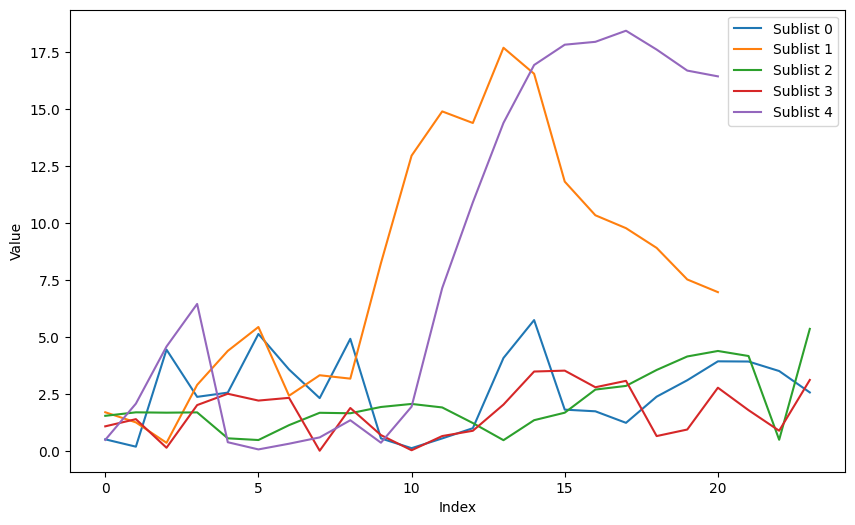

In [16]:
for i in range(len(Absulute_err)):
    Absulute_err[i] = [abs(x) for x in Absulute_err[i] if abs(x) <= 900]
    print(sum(Absulute_err[i])/len(Absulute_err[i]))
plt.figure(figsize=(10, 6))
for i, sublist in enumerate(Absulute_err):
    plt.plot(sublist, label=f'Sublist {i}')
plt.legend()
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()


TODO: Try CNN's potential for U-nets and Latent space of VAE's, Diff time steps, Optimizers, Add Dimensions for differnet variables (i.e. add a dimension for 500 mb data), point v gridded forecast, spacing out data (i.e. bigger grid scaling)